In [1]:
#from threadpoolctl import threadpool_info, threadpool_limits
#from pprint import pprint
#pprint(threadpool_info())

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import theano
import graphviz
import os
import sys
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
pm.__version__

'3.8'

In [4]:
#from threadpoolctl import threadpool_info
#from pprint import pprint
#pprint(threadpool_info())

### PyMC3 GLM Example: https://docs.pymc.io/notebooks/GLM-linear.html

Linear model with a single explanatory variable:
\begin{equation}
    y_{i} = \beta_{0} + \beta_{1}x_{i1} + \epsilon_{i}, \quad \epsilon_{i} \sim \mathcal{N}(0, \sigma^2), \quad
    i = 1, \ldots, N
\end{equation}

In [5]:
size = 400
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

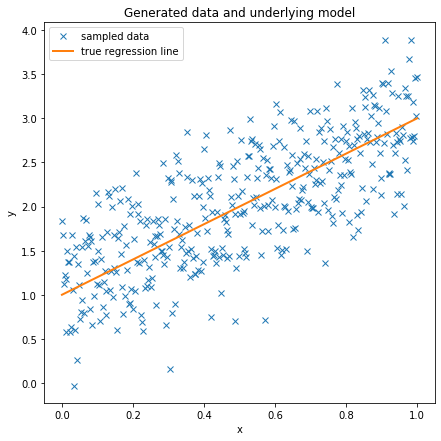

In [6]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [7]:
with pm.Model() as linear_model1: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.Gamma('sigma', alpha=5e-3, beta=1e-3)
    beta0 = pm.Normal('beta0', 0., sigma=20.)
    beta1 = pm.Normal('beta1', 0., sigma=20.)

    # Define likelihood
    likelihood = pm.Normal('y', mu=beta0 + beta1 * x, sigma=sigma, observed=y)

    # Inference!
    trace = pm.sample(draws=1000, step=pm.NUTS(), tune=2000, cores=4, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:09<00:00, 1321.54draws/s]


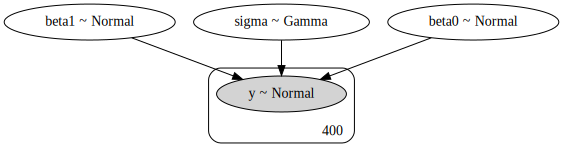

In [8]:
pm.model_to_graphviz(linear_model1)

<Figure size 504x504 with 0 Axes>

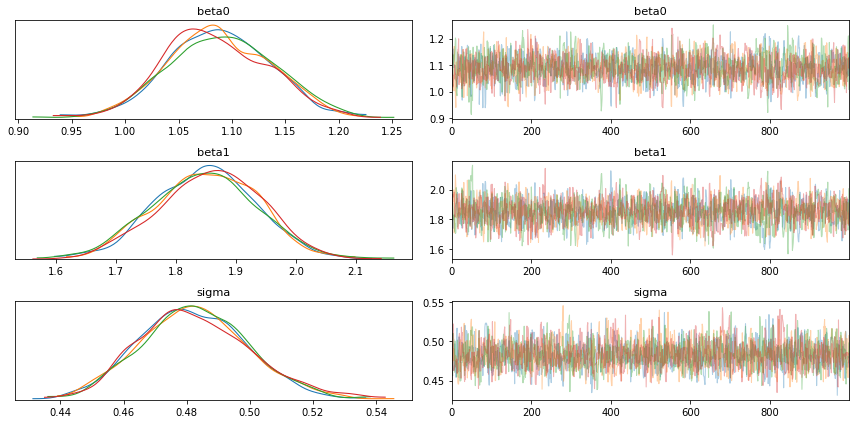

In [9]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout();

### Linear Regression with homescedastic error

Linear model with a multiple explanatory variables:
\begin{equation}
    y_{i} = \beta_{0} + \beta_{1}x_{i1} + \epsilon_{i}, \quad \epsilon_{i} \sim \mathcal{N}(0, \sigma^2), \quad
    i = 1, \ldots, N
\end{equation}

In [10]:
N = 200
k = 3
beta = np.array([[0.5], [2.5], [-3.]])
X = 10 * np.random.randn(N, k)
y = np.dot(X, beta) + np.random.randn(N, 1)


Text(0, 0.5, 'y')

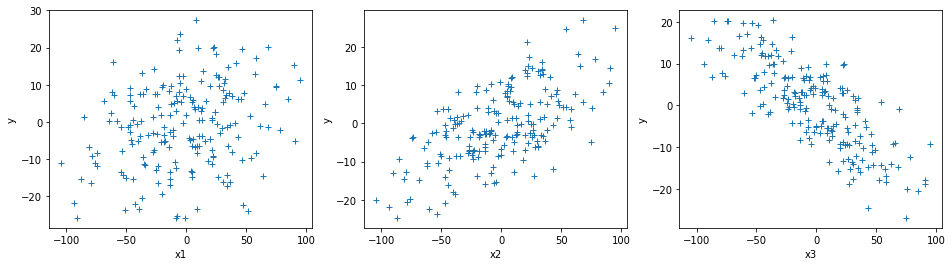

In [11]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].plot(y, X[:,0], '+')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('y')
axes[1].plot(y, X[:,1], '+')
axes[1].set_xlabel('x2')
axes[1].set_ylabel('y')
axes[2].plot(y, X[:,2], '+')
axes[2].set_xlabel('x3')
axes[2].set_ylabel('y')

In [12]:
with pm.Model() as linear_model2:
    beta0 = pm.Normal(mu=0, sigma=1e5, name='beta1')
    beta1 = pm.Normal(mu=0, sigma=1e5, name='beta2')
    beta2 = pm.Normal(mu=0, sigma=1e5, name='beta3')
    beta3 = pm.Normal(mu=0, sigma=1e5, name='beta4')
    sigma = pm.HalfCauchy(beta=100, name='sigma')
    mu = beta0 + beta1 * X[:,0] + beta2 * X[:,1] + beta3 * X[:,2]
    y_obs = pm.Normal(mu=mu, sigma=sigma, observed=y.ravel(), name='y')
    
    trace = pm.sample(draws=20000, tune=5000, cores=2, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta4, beta3, beta2, beta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 50000/50000 [00:30<00:00, 1626.37draws/s]


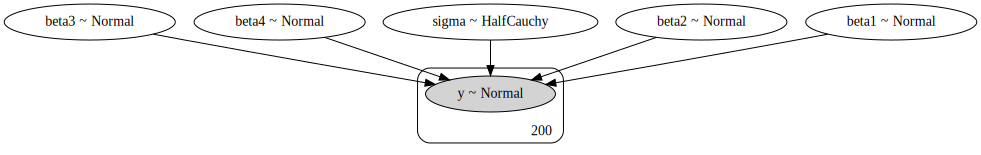

In [13]:
pm.model_to_graphviz(linear_model2)

<Figure size 504x504 with 0 Axes>

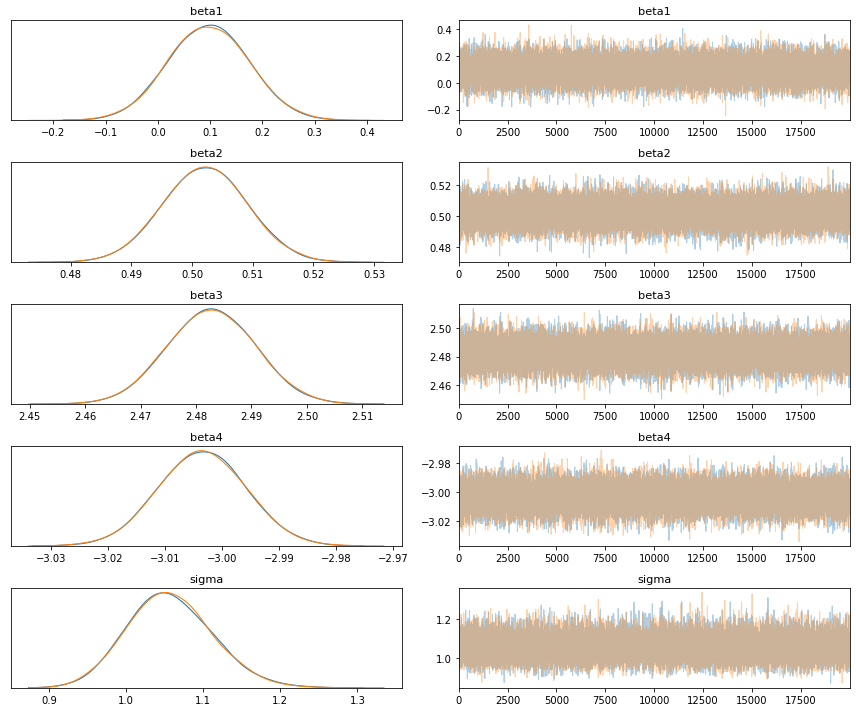

In [14]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout();

### Linear Regression with general covariance matrix

Linear model with a multiple explanatory variables, but written as matrix equation:
\begin{equation}
    y = X \beta + \epsilon, \quad \epsilon \sim \mathcal{N}(\mathbf{0}_{N}, \sigma^2 \mathbf{I}_{N}),\\
    y=\\
    X = \\
    beta = \\
\end{equation}

In [15]:
N = 200
k = 3
beta = np.array([[0.5], [2.5], [-3.]])
X = 10 * np.random.randn(N, k)
y = np.dot(X, beta) + np.random.randn(N, 1)


Text(0, 0.5, 'y')

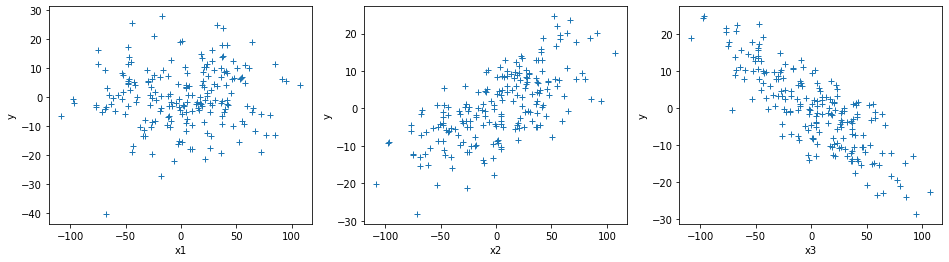

In [16]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].plot(y, X[:,0], '+')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('y')
axes[1].plot(y, X[:,1], '+')
axes[1].set_xlabel('x2')
axes[1].set_ylabel('y')
axes[2].plot(y, X[:,2], '+')
axes[2].set_xlabel('x3')
axes[2].set_ylabel('y')

In [17]:
with pm.Model() as linear_model3:
    beta = pm.Normal(mu=0, sigma=1e5, name='beta', shape=3)
    sigma = pm.HalfCauchy(beta=100, name='sigma')
    
    mu = pm.math.dot(X, beta)
    Sigma = pm.math.kronecker(np.eye(N) * sigma)
    
    y_obs = pm.MvNormal(mu=mu.ravel(), cov=Sigma, lower=True, observed=y.ravel(), name='y')
    
    trace = pm.sample(draws=2000, tune=500, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [05:08<00:00, 32.39draws/s]


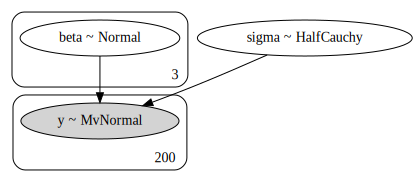

In [18]:
pm.model_to_graphviz(linear_model3)

<Figure size 504x504 with 0 Axes>

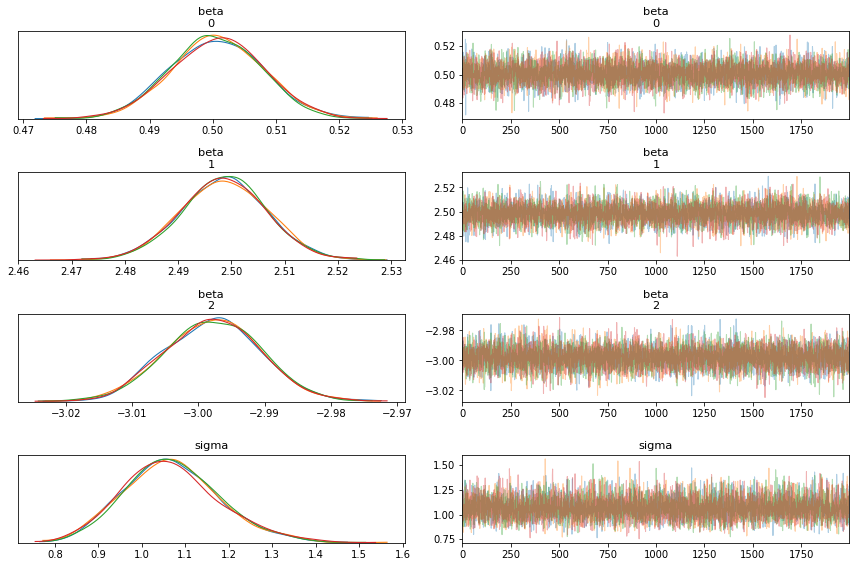

In [19]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace, compact=False)
plt.tight_layout();